In [ ]:
# code van stack overflow:

import ee
from ee import batch

ee.Initialize()

# Import shapefile
table = ee.FeatureCollection("users/italomoletto/LSat_ETr_Tiles")

# Load Landsat 8 surface reflectance data
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filter(ee.Filter.eq('WRS_PATH', 233))\
    .filter(ee.Filter.gt('WRS_ROW', 87)).filter(ee.Filter.lt('WRS_ROW', 91))

# Load Landsat 7 surface reflectance data
l7sr = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR').filter(ee.Filter.eq('WRS_PATH', 233))\
    .filter(ee.Filter.gt('WRS_ROW', 87)).filter(ee.Filter.lt('WRS_ROW', 91))


def getQABits(image, start, end, mascara):
    # Compute the bits we need to extract.
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
        
    # Return a single band image of the extracted QA bits, giving the     band a new name.
    return image.select([0], [mascara]).bitwiseAnd(pattern).rightShift(start)

# A function to mask out cloudy pixels.
def maskQuality(image):
    
    # Select the QA band.
    QA = image.select('pixel_qa')
    
    # Get the internal_cloud_algorithm_flag bit.
    sombra = getQABits(QA,3,3,'cloud_shadow')
    nubes = getQABits(QA,5,5,'cloud')
    
    #  var cloud_confidence = getQABits(QA,6,7,  'cloud_confidence')
    cirrus_detected = getQABits(QA,9,9,'cirrus_detected')
    #var cirrus_detected2 = getQABits(QA,8,8,  'cirrus_detected2')
    
    # Return an image masking out cloudy areas.
    return image.updateMask(sombra.eq(0)).updateMask(nubes.eq(0).updateMask(cirrus_detected.eq(0)))

L8SR = l8sr.filterDate('2017-01-01', '2017-12-31').map(maskQuality).filterBounds(table)
L7SR = l7sr.filterDate('2017-01-01', '2017-12-31').map(maskQuality).filterBounds(table)
llx = -71
lly = -42
urx = -73
ury = -41
geometry = [[llx,lly], [llx,ury], [urx,ury], [urx,lly]]
name_export='SR'

def ExportCol(col, folder, scale, typei, nimg, maxPixels, region):
    # typei = "float"
    # nimg = 500
    # scale = 1000
    # maxPixels = 1e10
    colList = col.toList(nimg)
    n = colList.size().getInfo()
    for i in range(0,n):
        img = ee.Image(colList.get(i))
        id_img = img.id().getInfo()
        
        # region = img.geometry().bounds().getInfo()["coordinates"]

        imgtype = {"float":img.toFloat(), 
                    "byte":img.toByte(), 
                    "int":img.toInt(),
                    "double":img.toDouble()
                  }
        task_config = {
            'image': imgtype[typei],
            'description': id_img,
            'scale': scale,  
            'region': region,
            'folder': folder,
            'maxPixels': maxPixels,
            'fileNamePrefix': id_img
            }
    
        task = batch.Export.image(img, name_export+id_img, task_config)
        task.start()
    
#//var ExportCol = function(col, folder, scale, type,
#//                         nimg, maxPixels, region)
ExportCol(L8SR,'SR',100,"float",200,1e12,geometry)

# REWRITE FOR SENTINEL3

In [136]:
# general imports
import math
import sys

# GEE imports
import ee
# from ee import batch
from geetools import batch
ee.Initialize()

def getQABits(image, start, end, mascara):
    # Compute the bits we need to extract.
    pattern = 0
    for i in range(start,end+1):
        pattern += 2**i
        
    # Return a single band image of the extracted QA bits, giving the     band a new name.
    return image.select([0], [mascara]).bitwiseAnd(pattern).rightShift(start)

# A function to mask out cloudy pixels.
def maskQuality(image):
    
    # Select the QA band.
    QA = image.select('quality_flags')
    
    # Get the internal_cloud_algorithm_flag bit.
    bright = getQABits(QA,27,27,'Bright') #4?
    invalid = getQABits(QA,25,25,'Invalid')
    
    #  var cloud_confidence = getQABits(QA,6,7,  'cloud_confidence')
    cosmetic = getQABits(QA,24,24,'Cosmetic')
    #var cirrus_detected2 = getQABits(QA,8,8,  'cirrus_detected2')
    
    # Return an image masking out cloudy areas.
    return image.updateMask(bright.eq(0)).updateMask(invalid.eq(0).updateMask(cosmetic.eq(0)))

def ExportCol(col, folder, scale, typei, nimg, maxPixels, region):
#     typei = "float"
    # nimg = 500
    # scale = 1000
    # maxPixels = 1e10
    colList = col.toList(nimg)
    n = colList.size().getInfo()
    print(n)
    for i in range(0,n):
        img_tmp = ee.Image(colList.get(i))
        img = get_MCI_clipped(img_tmp)
        
        # hack to get give the band the right name
        
        img = img.select([0], ['MCI'])
#         img = img.copyProperties(img_tmp)
        
        id_img = img_tmp.id().getInfo()
        print(id_img)
#         img_tmp = ee.Image(img_tmp)
        
        # region = img.geometry().bounds().getInfo()["coordinates"]

        imgtype = {"float":img.toFloat(), 
                    "byte":img.toByte(), 
                    "int":img.toInt(),
                    "double":img.toDouble()
                  }
        task_config = {
            'image': imgtype[typei],
            'description': id_img,
            'scale': scale,  
            'region': region,
            'folder': folder,
            'maxPixels': maxPixels,
            'fileNamePrefix': id_img
            }
        
        # toLocal(image, name=None, path=None, scale=None, region=None, dimensions=None, toFolder=True)
        batch.Download.image.toLocal(img, name=name_export+id_img, scale=scale, region=region, path=folder, toFolder=True)
        batch.Download.image.toLocal(img_tmp.select(['quality_flags']), name=name_export+id_img, scale=scale, region=region, path=folder, toFolder=True)
#         task = batch.Export.image(img, name_export+id_img, task_config)
#         task.start()
    
    
def get_MCI_clipped(img):
    """convert ee.Image to MCI ee.Image"""
    img = img.clip(ijssel_rect);
    # get bright pixels
    QA = img.select(['quality_flags']);
    bright_pix = getQABits(QA, 24,27, 'Bright').eq(0);
  
    # calculate MCI
    # bands can be found here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S3_OLCI
    MCI = img.expression(
        'l709 - l681 - (((709-681)/(753-681)) * (l753-l681))', {
        'l709': img.select('Oa11_radiance'),
        'l681': img.select('Oa10_radiance'),
        'l753': img.select('Oa12_radiance')
    })
    MCI = MCI.copyProperties(img)
    MCI = ee.Image(MCI)
    return MCI

In [260]:
# import polygons
from gee_polygons import ijssel_rect, ijssel_precise, ijssel_poly

daterange = ("2018-06-01", "2018-07-01")
daterangestr = "{}_{}".format(daterange[0], daterange[1])

# sentinel3 data
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S3_OLCI
dataset = ee.ImageCollection('COPERNICUS/S3/OLCI').filterBounds(ijssel_rect).filterDate(daterange[0], daterange[1])
dataset.map(maskQuality)

llx = -71
lly = -42
urx = -73
ury = -41
geometry = [[llx,lly], [llx,ury], [urx,ury], [urx,lly]]
name_export='MCI_TEST_MASK'

# ExportCol = function(col, folder, scale, type, nimg, maxPixels, region)

ExportCol(dataset,'TESTNEW_MCI',300,"float",300,1e12, ijssel_rect)

37
S3A_20180601T101722_20180601T102022
S3A_20180602T095111_20180602T095411
S3A_20180602T095411_20180602T095711
S3A_20180603T092500_20180603T092800
S3A_20180603T092800_20180603T093100
S3A_20180604T103948_20180604T104248
S3A_20180605T101337_20180605T101637
S3A_20180606T094726_20180606T095026
S3A_20180606T095026_20180606T095326
S3A_20180607T092415_20180607T092715
S3A_20180608T103604_20180608T103904
S3A_20180609T100953_20180609T101253
S3A_20180610T094342_20180610T094642
S3A_20180610T094642_20180610T094942
S3A_20180612T103219_20180612T103519
S3A_20180613T100608_20180613T100908
S3A_20180614T093958_20180614T094258
S3A_20180614T094258_20180614T094558
S3A_20180616T102835_20180616T103135


KeyboardInterrupt: 

(299, 186, 3)
max:  1.0291022
min: 0.0


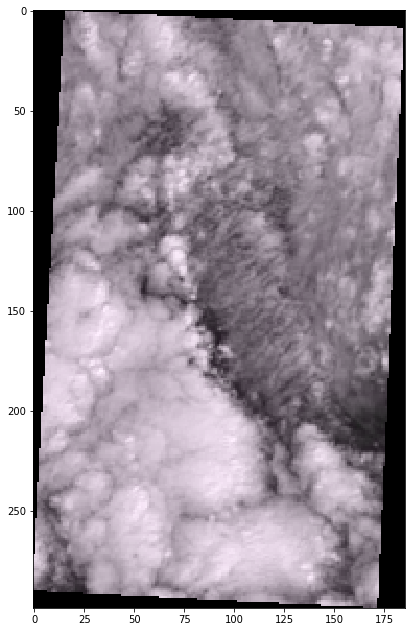

In [252]:
# gtif = gdal.Open("MCI_0_2018-06-01/dbe06822e4728a39578506dd3e5b04f1.Oa11_radiance.tif")
gtif1 = gdal.Open("exports/test_pieter/RGB/RGB_2018-06-13/ea6dd33dd66174c62ab5c4c39b797414.Oa04_radiance.tif")
gtif2 = gdal.Open("exports/test_pieter/RGB/RGB_2018-06-13/ea6dd33dd66174c62ab5c4c39b797414.Oa06_radiance.tif")
gtif3 = gdal.Open("exports/test_pieter/RGB/RGB_2018-06-13/ea6dd33dd66174c62ab5c4c39b797414.Oa04_radiance.tif")
image1 = gtif1.ReadAsArray()
image2 = gtif2.ReadAsArray()
image3 = gtif3.ReadAsArray()

image = np.stack((image1, image2, image3), axis=-1) / 6 # scale data between 0 & 1, Sentinel3 specific scale

print(image.shape)
print("max: ", np.max(image))
print("min:", np.min(image))
image[image > 6] = np.max(image)
image[image > 1] = 1 # clip rounding errors
f, axs = plt.subplots(figsize=(20,11))
plt.imshow(image)
plt.show()

In [304]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
# gtif1 = gdal.Open("TESTNEW_MCI/MCI_TEST_MASKS3A_20180610T094342_20180610T094642/bdfd7dc59e722f79eaa773d72cb5254f.MCI.tif")
gtif1 = gdal.Open("TESTNEW_MCI/MCI_TEST_MASKS3A_20180610T094342_20180610T094642/S3A_20180610T094342_20180610T094642.quality_flags.tif")
image = gtif1.ReadAsArray()

(299, 186)
max:  5.0555553
min: -29.666666
476


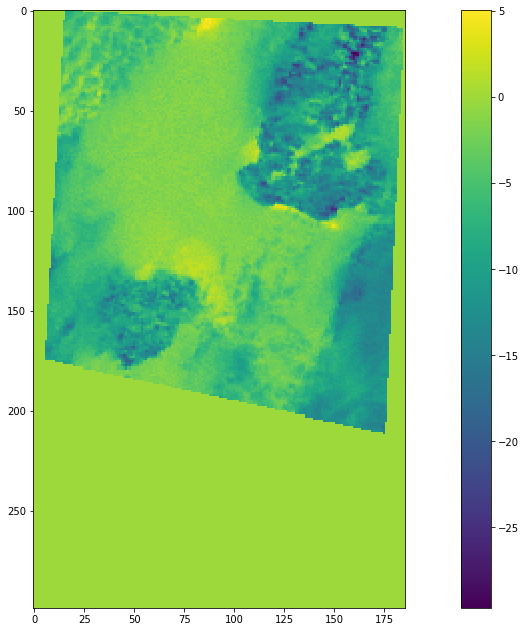

In [303]:
# image[image<-10] = -10
# image[~image == 2552242273] = 0
# image[image == 2552234081] = 1
print(image.shape)
print("max: ", np.max(image))
print("min:", np.min(image))
# print(image[0,0])

print(len(np.unique(image)))
# print(np.unique(image))
f, axs = plt.subplots(figsize=(20,11))
plt.imshow(image)
cbar = plt.colorbar()
plt.show()

In [305]:
import numpy as np

get_bitvector = lambda x: "{0:b}".format(x)
expand_bitvector = lambda s: np.fromstring(s,'u1') - ord('0')

vfunc = np.vectorize(get_bitvector)
flatty = image.flatten()
result = vfunc(flatty)
result = result.reshape(image.shape)

expanded_mask = np.zeros((image.shape[0], image.shape[1], 32), dtype=np.uint8)
error_count = 0
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        bit_array = vfunc2(result[i,j])
        if len(bit_array) < 32:
            tmp = np.zeros(32, dtype=np.uint8)
            tmp[-len(bit_array):] = bit_array
            bit_array = tmp
        if len(bit_array) < 32:
            error_count+=1

        expanded_mask[i,j,:len(bit_array)] = bit_array

print('error count: {}'.format(error_count))

/data/anaconda3/envs/gee/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


error count: 0


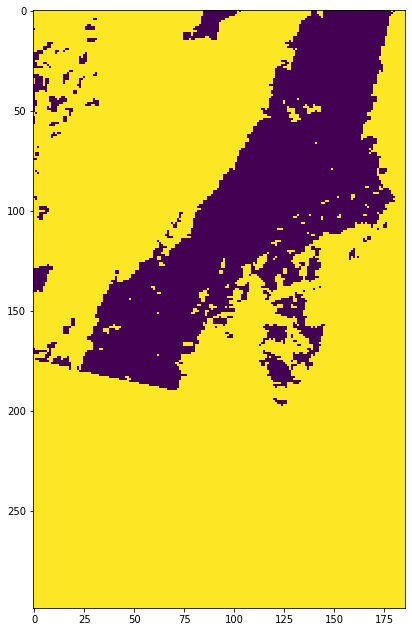

In [306]:
f, axs = plt.subplots(figsize=(20,11))
plt.imshow(expanded_mask[:,:,4])
plt.show()